In [27]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt

In [2]:
# Load the data
df = pd.read_csv('.csv/cleaned_data.csv', index_col = 0)
model_data = df.copy()
pd.set_option('display.max_column', None)

In [3]:
model_data.replace(np.inf, np.nan, inplace=True)

In [4]:
# Convert categorical columns to string first, then to category
model_data['NewExist_Encoded'] = model_data['NewExist'].map({1.0: 1, 2.0: 0}, na_action='ignore') \
                                                      .fillna('missing') \
                                                      .astype('str') \
                                                      .astype('category')

model_data['UrbanRural_Encoded'] = model_data['UrbanRural'].map({1.0: 1, 2.0: 0}, na_action='ignore') \
                                                          .fillna('missing') \
                                                          .astype('str') \
                                                          .astype('category')

model_data['MIS_Status_Encoded'] = model_data['MIS_Status'].map({'CHGOFF': 0, 'PIF': 1}) \
                                                          .fillna('missing') \
                                                          .astype('str') \
                                                          .astype('category')

model_data['RevLineCr_Encoded'] = model_data['RevLineCr'].map({'N': 0, 'Y': 1}, na_action='ignore') \
                                                      .fillna('missing') \
                                                      .astype('str') \
                                                      .astype('category')

model_data['LowDoc_Encoded'] = model_data['LowDoc'].map({'N': 0, 'Y': 1}) \
                                                  .fillna('missing') \
                                                  .astype('str') \
                                                  .astype('category')

model_data['FranchiseCode_Encoded'] = model_data['FranchiseCode_Encoded'].map({'No': 0, 'Yes': 1}) \
                                                                    .fillna('missing') \
                                                                    .astype('str') \
                                                                    .astype('category')

model_data['RealEstate_Backed'] = model_data['RealEstate_Backed'].map({'No': 0, 'Yes': 1}) \
                                                              .fillna('missing') \
                                                              .astype('str') \
                                                              .astype('category')

model_data['CreateJob_Encoded'] = model_data['CreateJob'].apply(lambda x: 1 if x > 0 else 0) \
                                                      .astype('str') \
                                                      .astype('category')

model_data['RetainedJob_Encoded'] = model_data['RetainedJob'].apply(lambda x: 1 if x > 0 else 0) \
                                                        .astype('str') \
                                                        .astype('category')

model_data['State'] = model_data['State'].fillna('missing').astype('str').astype('category')

model_data['StateRisk'] = model_data['StateRisk'].fillna('missing').astype('str').astype('category')

model_data['Region'] = model_data['Region'].fillna('missing').astype('str').astype('category')

model_data['NAICS_class_code'] = model_data['NAICS_class_code'].fillna('missing').astype('str').astype('category')


In [5]:
model_data.loc[:, 'EmployeeLoanRatio'] = model_data.apply(
    lambda row: round(row['GrAppv']) if pd.isna(row['EmployeeLoanRatio']) else round(row['EmployeeLoanRatio']),
    axis=1
).astype('int64')

In [6]:
model_data.drop(labels=['LoanNr_ChkDgt', 'Name', 'City', 'Bank', 'BankState', 'TermDays', 'ApprovalDate', 'ApprovalFY', 'Zip', 'DisbursementDate', 
                      'DisbursementGross','NewExist', 'RetainedJob', 'LowDoc' ,'UrbanRural', 'RevLineCr', 'ChgOffDate',
                      'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'SBA_Appv', 'Industry', 'Recession',
                       'ApprovalDateYear', 'ChgOffDateYear', 'ApprovalDateMonth', 'DisbursementDateYear',
                       'LoanDateEnd'], axis=1, inplace=True )

In [7]:
model_data.head()

,State,NAICS,Term,NoEmp,CreateJob,FranchiseCode,GrAppv,NAICS_class_code,FranchiseCode_Encoded,RealEstate_Backed,Region,EmployeeLoanRatio,StateRisk,NewExist_Encoded,UrbanRural_Encoded,MIS_Status_Encoded,RevLineCr_Encoded,LowDoc_Encoded,CreateJob_Encoded,RetainedJob_Encoded
0,IN,451120,84,4,0,1,60000,45,0,0,Eastern,15000.0,Medium,0.0,missing,1,0.0,1,0,0
1,IN,722410,60,2,0,1,40000,72,0,0,Eastern,20000.0,Medium,0.0,missing,1,0.0,1,0,0
2,IN,621210,180,7,0,1,287000,62,0,0,Eastern,41000.0,Medium,1.0,missing,1,0.0,0,0,0
3,OK,0,60,2,0,1,35000,81,0,0,Eastern,17500.0,Low,1.0,missing,1,0.0,1,0,0
4,FL,0,240,14,7,1,229000,81,0,1,Eastern,16357.0,High,1.0,missing,1,0.0,0,1,1


In [8]:
from sklearn.model_selection import train_test_split

# Split the data into features and target
X = model_data.drop(columns=['MIS_Status_Encoded'])
y = model_data['MIS_Status_Encoded']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [10]:
import catboost as cb

# Define model
cb_model = cb.CatBoostClassifier(#task_type="GPU",
                                random_state=42,
                                scale_pos_weight= 1.0,
                                random_strength= 10.0,
                                learning_rate= 0.38,
                                l2_leaf_reg= 4.5,
                                iterations= 1000,
                                depth= 11,
                                border_count= 128,
                                bagging_temperature= 0.0,
                                verbose=100,  # Log every 100 iterations
                            )

categorical_features_indices = [X_train.columns.get_loc(col) for col in X_train.select_dtypes(include=['category']).columns]

cb_model.fit(X_train, y_train, cat_features=categorical_features_indices)

cb_train_score = cb_model.score(X_train, y_train)

print("Training Score:", round(cb_train_score, 2))

# Store model parameters in a DataFrame
best_cb_params = cb_model.get_params()  # Get model's hyperparameters
best_cb_params_df = pd.DataFrame([best_cb_params])

# Save to CSV
best_cb_params_df.to_csv("best_cb_params.csv", index=False)

print("Best parameters saved to CSV successfully!")

0:	learn: 0.4170822	total: 1.54s	remaining: 25m 41s
100:	learn: 0.1392130	total: 1m 23s	remaining: 12m 26s
200:	learn: 0.1207031	total: 2m 45s	remaining: 10m 57s
300:	learn: 0.1079831	total: 4m 19s	remaining: 10m 2s
400:	learn: 0.0987944	total: 5m 37s	remaining: 8m 23s
500:	learn: 0.0903173	total: 7m 5s	remaining: 7m 3s
600:	learn: 0.0834116	total: 8m 38s	remaining: 5m 44s
700:	learn: 0.0769166	total: 10m 8s	remaining: 4m 19s
800:	learn: 0.0718537	total: 11m 39s	remaining: 2m 53s
900:	learn: 0.0669095	total: 13m 1s	remaining: 1m 25s
999:	learn: 0.0623995	total: 14m 18s	remaining: 0us
Training Score: 0.98
Best parameters saved to CSV successfully!


In [11]:
from sklearn.metrics import classification_report

# Make predictions
cb_y_pred = cb_model.predict(X_test)

# Calculate the accuracy
cb_classification_report = classification_report(y_test, cb_y_pred)

print(cb_classification_report)

              precision    recall  f1-score   support

           0       0.84      0.81      0.83     31564
           1       0.96      0.97      0.96    147922

    accuracy                           0.94    179486
   macro avg       0.90      0.89      0.90    179486
weighted avg       0.94      0.94      0.94    179486



In [ ]:
from sklearn.model_selection import cross_val_score

# Evaluate model using cross-validation
lgb_roc_scores = cross_val_score(cb_model, X_train, y_train, cv=5, scoring='roc_auc', error_score='raise')
print(f'ROC-AUC: {lgb_roc_scores.mean()}')

In [12]:
from catboost import CatBoostClassifier, Pool

cat_boost_params = {
    'scale_pos_weight': 1.0,
    'random_strength': 10.0,
    'learning_rate': 0.24,
    'l2_leaf_reg': 5.0,
    'iterations': 900,
    'depth': 12,
    'border_count': 128,
    'bagging_temperature': 0.3
}

cat_boost_best = CatBoostClassifier(
    random_state=42,
    verbose=100,  # Log every 100 iterations
    **cat_boost_params  # Apply your optimal parameters
)

# Detect categorical features
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Get the indices of these columns
categorical_features_indices = [X.columns.get_loc(col) for col in categorical_features]

# Create data pools
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
test_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)

cat_boost_best.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

0:	learn: 0.4887134	test: 0.4884369	best: 0.4884369 (0)	total: 1.65s	remaining: 24m 39s
100:	learn: 0.1484334	test: 0.1548779	best: 0.1548779 (100)	total: 1m 10s	remaining: 9m 19s
200:	learn: 0.1267665	test: 0.1487949	best: 0.1487927 (197)	total: 3m 10s	remaining: 11m 1s
300:	learn: 0.1120995	test: 0.1485540	best: 0.1484838 (263)	total: 5m 26s	remaining: 10m 50s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1484838015
bestIteration = 263

Shrink model to first 264 iterations.


In [13]:
from sklearn.metrics import classification_report

# Make predictions
cat_y_pred = cat_boost_best.predict(X_test)

# Calculate the accuracy
cat_classification_report = classification_report(y_test, cat_y_pred)

print(cat_classification_report)

              precision    recall  f1-score   support

           0       0.85      0.82      0.84     31564
           1       0.96      0.97      0.97    147922

    accuracy                           0.94    179486
   macro avg       0.91      0.89      0.90    179486
weighted avg       0.94      0.94      0.94    179486



In [32]:
from catboost import cv

cv_params = {
    'random_strength': 10.0,
    'learning_rate': 0.24,
    'l2_leaf_reg': 5.0,
    'iterations': 800,
    'depth': 12,
    'border_count': 128,
    'bagging_temperature': 0.3,
    'verbose': 100,
    'random_state': 42,
    'eval_metric': 'AUC',
    'loss_function': 'Logloss'  # Use Logloss for binary classification
}


cv_data = cv(
    params=cv_params,
    pool=train_pool,
    fold_count=5,  # 5-Fold Cross-Validation
    early_stopping_rounds=50,
    stratified=True,  # Ensure stratified folds
    partition_random_seed=42
)

# Display column names to confirm
print(cv_data.columns)

# Get the best AUC score
best_auc = cv_data['test-AUC-mean'].max()
print(f"Best Mean ROC-AUC Score: {best_auc}")


Training on fold [0/5]
0:	test: 0.8461889	best: 0.8461889 (0)	total: 1.53s	remaining: 20m 23s
100:	test: 0.9732810	best: 0.9732810 (100)	total: 1m 4s	remaining: 7m 27s
200:	test: 0.9750639	best: 0.9750752 (197)	total: 2m 13s	remaining: 6m 37s

bestTest = 0.975085202
bestIteration = 233

Training on fold [1/5]
0:	test: 0.8465291	best: 0.8465291 (0)	total: 1.22s	remaining: 16m 17s
100:	test: 0.9722715	best: 0.9722715 (100)	total: 1m	remaining: 7m 1s
200:	test: 0.9740803	best: 0.9740936 (198)	total: 2m 11s	remaining: 6m 32s

bestTest = 0.9741197373
bestIteration = 211

Training on fold [2/5]
0:	test: 0.8446258	best: 0.8446258 (0)	total: 446ms	remaining: 5m 56s
100:	test: 0.9729064	best: 0.9729064 (100)	total: 54.5s	remaining: 6m 17s
200:	test: 0.9743511	best: 0.9743531 (197)	total: 2m 7s	remaining: 6m 19s

bestTest = 0.9744296298
bestIteration = 219

Training on fold [3/5]
0:	test: 0.8448449	best: 0.8448449 (0)	total: 563ms	remaining: 7m 29s
100:	test: 0.9727089	best: 0.9727089 (100)	tota

In [22]:
# Print available columns to check keys
print(cv_data.columns)

# Access the correct metric name
best_logloss = cv_data['test-Logloss-mean'].min()
print(f"Best Mean Logloss: {best_logloss}")


Index(['iterations', 'test-Logloss-mean', 'test-Logloss-std',
       'train-Logloss-mean', 'train-Logloss-std'],
      dtype='object')
Best Mean Logloss: 0.14599035796803722


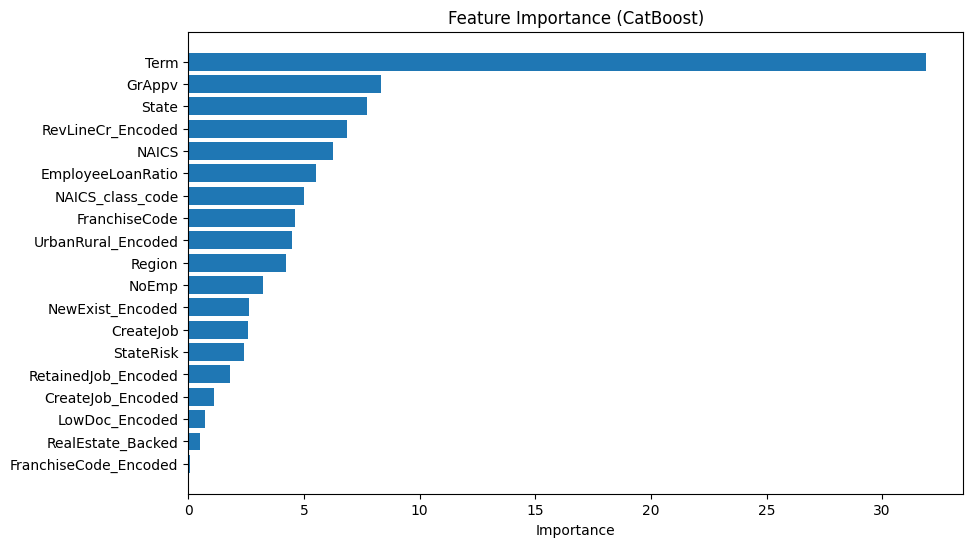

In [31]:
# Vizualize Feature Importance
feature_importance = pd.DataFrame({'Feature': cb_model.feature_names_, 'Importance': cb_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (CatBoost)')
plt.gca().invert_yaxis()
plt.show()


X_train shape: (717942, 19)
X_test shape: (179486, 19)


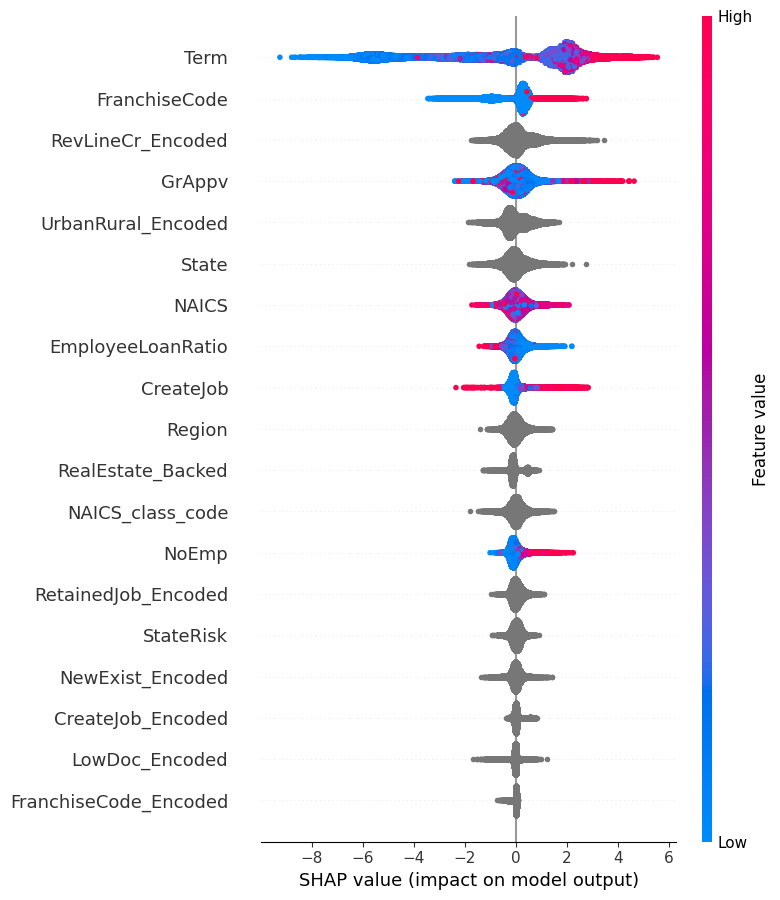

In [29]:
import shap

# Ensure X_test has the same columns as X_train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Convert boolean columns to integers
X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes(include=['bool']).columns})
X_test = X_test.astype({col: 'int' for col in X_test.select_dtypes(include=['bool']).columns})

# Check for shape mismatches
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Create SHAP Explainer
explainer = shap.TreeExplainer(cb_model, feature_perturbation="tree_path_dependent")

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# Plot Summary
shap.summary_plot(shap_values, X_test)
